In [ ]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
os.chdir("/content/drive/MyDrive/DSPP Fake News")
buzzfeed = pd.read_csv('buzzfeed.csv') #read csvs
politifact = pd.read_csv('politifact.csv')

In [ ]:
buzzfeed.drop(buzzfeed.columns[0], axis=1, inplace=True) #drop index cols
politifact.drop(politifact.columns[0], axis=1, inplace=True)

In [ ]:
buzzfeed['origin'] = 'buzzfeed'
politifact['origin'] = 'politifact'

In [ ]:
fakenews_df = pd.concat([buzzfeed, politifact])

In [ ]:
#fakenews_df = politifact

In [ ]:
fakenews_df.head()

,source,date,title,text,fake,date_time,origin
0,http://www.addictinginfo.org,2016-09-19,Proof The Mainstream Media Is Manipulating The...,I woke up this morning to find a variation of ...,1,2016-09-18 20:00:00,buzzfeed
1,http://eaglerising.com,2016-09-21,"Charity: Clinton Foundation Distributed ""Water...",Former President Bill Clinton and his Clinton ...,1,2016-09-20 20:08:41,buzzfeed
2,http://eaglerising.com,2016-09-21,A Hillary Clinton Administration May be Entire...,After collapsing just before trying to step in...,1,2016-09-20 20:10:38,buzzfeed
3,http://www.addictinginfo.org,2016-09-19,Trump’s Latest Campaign Promise May Be His Mos...,"Donald Trump is, well, deplorable. He’s sugges...",1,2016-09-18 20:00:00,buzzfeed
4,http://www.proudcons.com,NaN,Website is Down For Maintenance,Website is Down For Maintenance,1,NaN,buzzfeed


In [ ]:
textonly = pd.concat([fakenews_df['title'], fakenews_df['text']])

Exploratory analysis

In [ ]:
import datetime as dt

In [ ]:
dates = fakenews_df[['date', 'fake', 'date_time']].dropna()

In [ ]:
dates['date'] = pd.to_datetime(dates['date'])
dates['date_time'] = pd.to_datetime(dates['date_time'])
dates = dates[dates.fake == 1]

In [ ]:
dates['date_time'] = dates['date_time'].dt.strftime('%H')

In [ ]:
dates[['date', 'fake']].groupby('date').count().reset_index()

,date,fake
0,2013-03-05,1
1,2014-02-28,1
2,2015-03-09,1
3,2015-04-22,1
4,2015-05-26,1
...,...,...
88,2017-07-14,1
89,2017-07-20,1
90,2017-07-28,1
91,2017-07-30,1


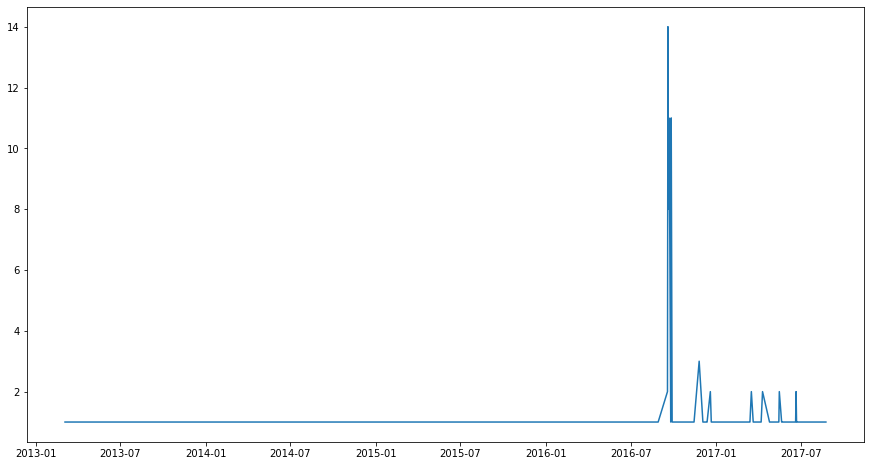

In [ ]:
plt.figure(figsize=(15,8))

df_plot = dates[['date', 'fake']].groupby('date').count().reset_index()
plt.plot(df_plot['date'], df_plot['fake'])

In [ ]:
dates[['date', 'fake']].value_counts()

date        fake
2016-09-19  1       14
2016-09-26  1       11
2016-09-21  1       11
2016-09-22  1        9
2016-09-20  1        8
                    ..
2017-05-12  1        1
2017-05-13  1        1
2017-05-15  1        1
2017-05-21  1        1
2013-03-05  1        1
Length: 93, dtype: int64

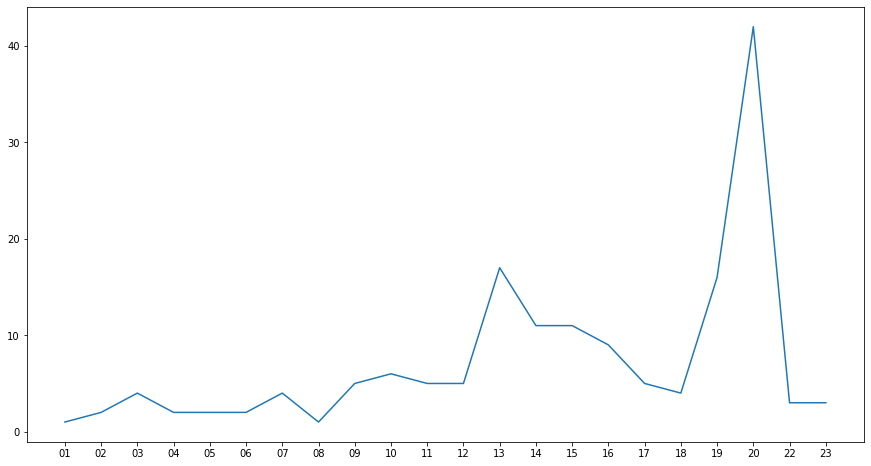

In [ ]:
plt.figure(figsize=(15,8))

df_plot = dates[['date_time', 'fake']].groupby('date_time').count().reset_index()
plt.plot(df_plot['date_time'], df_plot['fake'])

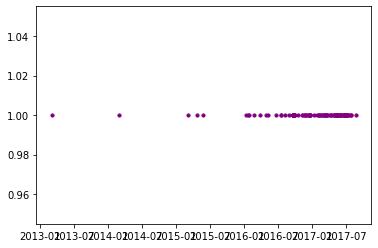

In [ ]:
plt.scatter(x = dates['date'], y = dates['fake'], s = 10, color='purple')

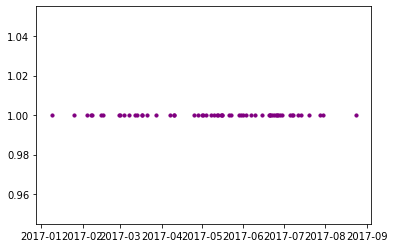

In [ ]:
plt.scatter(x = dates[dates.date >= '2017-01-01']['date'], y = dates[dates.date >= '2017-01-01']['fake'], s = 10, color='purple')

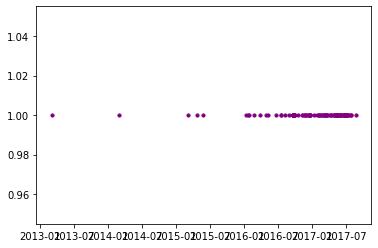

In [ ]:
plt.scatter(x = dates['date'], y = dates['fake'], s = 10, color='purple')

In [ ]:
# what is the distribution of Y?
fakenews_df['fake'].value_counts()

1    211
0    211
Name: fake, dtype: int64

In [ ]:
# what source is most frequent
fakenews_df['source'].value_counts()

http://politi.co              75
http://cnn.it                 45
http://rightwingnews.com      28
http://eaglerising.com        23
http://freedomdaily.com       20
                              ..
http://fb.me                   1
http://redherald.com           1
https://halfwaypost.com        1
http://snoopack.com            1
http://themiamigazette.com     1
Name: source, Length: 104, dtype: int64

In [ ]:
#when was the most fake news published?
dates[['date', 'fake']].value_counts()

date        fake
2016-09-19  1       14
2016-09-26  1       11
2016-09-21  1       11
2016-09-22  1        9
2016-09-20  1        8
                    ..
2017-05-12  1        1
2017-05-13  1        1
2017-05-15  1        1
2017-05-21  1        1
2013-03-05  1        1
Length: 93, dtype: int64

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

Classification models

In [ ]:
import time
import scipy.sparse as sp
from sklearn.decomposition import PCA

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer

In [ ]:
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
def lemmatize_text(s):
    s = [wordnet_lemmatizer.lemmatize(w) for w in s]
    return s

In [ ]:
fakenews_df_2 = fakenews_df[['fake', 'title', 'text']].dropna()

In [ ]:
fakenews_df_2['both'] = fakenews_df_2['title'].str.cat(fakenews_df_2['text'],sep=" ")

In [ ]:
X = lemmatize_text(fakenews_df_2['both'])
Y = fakenews_df_2['fake']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = .33)

In [ ]:
pipe = Pipeline([('tfidf', CountVectorizer(ngram_range = (1,2), binary = True)),
                 ('trans', TfidfTransformer(use_idf=False, norm='l2', smooth_idf=False)),
                  ('bayes', MultinomialNB())
                  ])

bayes_params = {
    'bayes__alpha': [1, .5, 1e-1, 1e-2, 1e-3],
    'bayes__fit_prior': [True, False],
}

bayes_cv = GridSearchCV(estimator= pipe, param_grid = bayes_params, cv = 3, scoring="accuracy")

bayes_cv.fit(X = X_train, y = y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('tfidf',
                                        CountVectorizer(analyzer='word',
                                                        binary=True,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 2),
                                                        prep

In [ ]:
print(bayes_cv.best_params_)

{'bayes__alpha': 0.01, 'bayes__fit_prior': True}


In [ ]:
y_pred = bayes_cv.predict(X_test)

accuracy_score(y_test, y_pred)

0.8145161290322581

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, bayes_cv.predict(X_test), digits=4))

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
CM = confusion_matrix(y_test, bayes_cv.predict(X_test))
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()

In [ ]:
from sklearn.naive_bayes import GaussianNB

In [ ]:
pipe2 = Pipeline([('gauss', GaussianNB())])

In [ ]:
gauss_params = {
    'gauss__var_smoothing': [1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9],
}

In [ ]:
gauss_cv = GridSearchCV(estimator= pipe2, param_grid = gauss_params, cv = 3)

In [ ]:
gauss_cv.fit(X = X_train, y = y_train)

In [ ]:
print(gauss_cv.best_params_)

In [ ]:
y_pred = gauss_cv.predict(X_test)

In [ ]:
accuracy_score(y_test, y_pred)

In [ ]:
print(classification_report(y_test, y_pred, digits=4))
CM = confusion_matrix(y_test, y_pred)
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()

In [ ]:
from sklearn.naive_bayes import BernoulliNB

In [ ]:
pipe = Pipeline([('bayes', BernoulliNB())])

bayes_params = {
    'bayes__alpha': [1.1, 1, 1e-1, 1e-2],
    'bayes__binarize': [0, 1.1, 1, 1e-1, 1e-2, 1e-3],
    'bayes__fit_prior': [True, False],
}

bayes_cv = GridSearchCV(estimator= pipe, param_grid = bayes_params, cv = 3)

bayes_cv.fit(X = X_train, y = y_train)

In [ ]:
print(bayes_cv.best_params_)

In [ ]:
y_pred = bayes_cv.predict(X_test)

accuracy_score(y_test, y_pred)

In [ ]:
print(classification_report(y_test, y_pred, digits=4))
CM = confusion_matrix(y_test, y_pred)
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()

In [ ]:
from xgboost import XGBClassifier

In [ ]:
pipeline = Pipeline([('xgb', XGBClassifier())])

param_grid = {
    'xgb__max_depth': [2, 3, 5],
    'xgb__n_estimators': [100, 500],
}

xgb_grid = GridSearchCV(pipeline, param_grid, cv = 3, verbose = 2)

xgb_grid.fit(X = X_train, y = y_train)

In [ ]:
#from joblib import dump
#dump(bayes_cv, 'bayes_cv.joblib')

In [ ]:
#from joblib import load
#model_bayes_cv = load('bayes_cv.joblib')

# Text Generation

In [ ]:
!pip install markovify
import markovify

In [ ]:
training_text = fakenews_df_2.copy()

In [ ]:
fakenews_df_2

In [ ]:
training_text = training_text[training_text.fake == 1]
training_text = training_text['both']

In [ ]:
model_markov_baseline = markovify.Text(training_text, state_size=1)

In [ ]:
sentence_markov_baseline = []
for _ in range(1000):
    sentence = model_markov_baseline.make_short_sentence(max_chars = 140)
    if sentence is not None:
      sentence_markov_baseline.append(sentence)

In [ ]:
sentence_markov_baseline

In [ ]:
df = pd.DataFrame(sentence_markov_baseline, columns= ['new_text'])

In [ ]:
df = df.drop_duplicates()

In [ ]:
df.shape

In [ ]:
df['fake'] = 1

In [ ]:
y_true = df['fake']
X = df['new_text']

In [ ]:
y_pred = model_bayes_cv.predict(X)

In [ ]:
accuracy_score(y_pred, y_true)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true, model_bayes_cv.predict(X), digits=4))


import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
CM = confusion_matrix(y_true, model_bayes_cv.predict(X))
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()

In [ ]:
def tweets_report(tweet_list):
    proba_list = model_bayes_cv.predict_proba(tweet_list)

    dummy_list = list(map(lambda x : (x>0.5).astype(int), proba_list))

    print('Proportion of headlines that fooled the classifier: ', np.mean(dummy_list))


In [ ]:
df['preds'] = y_pred 

In [ ]:
pd.set_option('display.max_colwidth', -1)

df[df['preds'] == 0]

In [ ]:
df.iloc[237]